# Feature Selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
from sklearn.decomposition import PCA

# Loading Training data

In [2]:
train = pd.read_csv('data/processed/train_eng.csv')

# Checking multi-collinearity

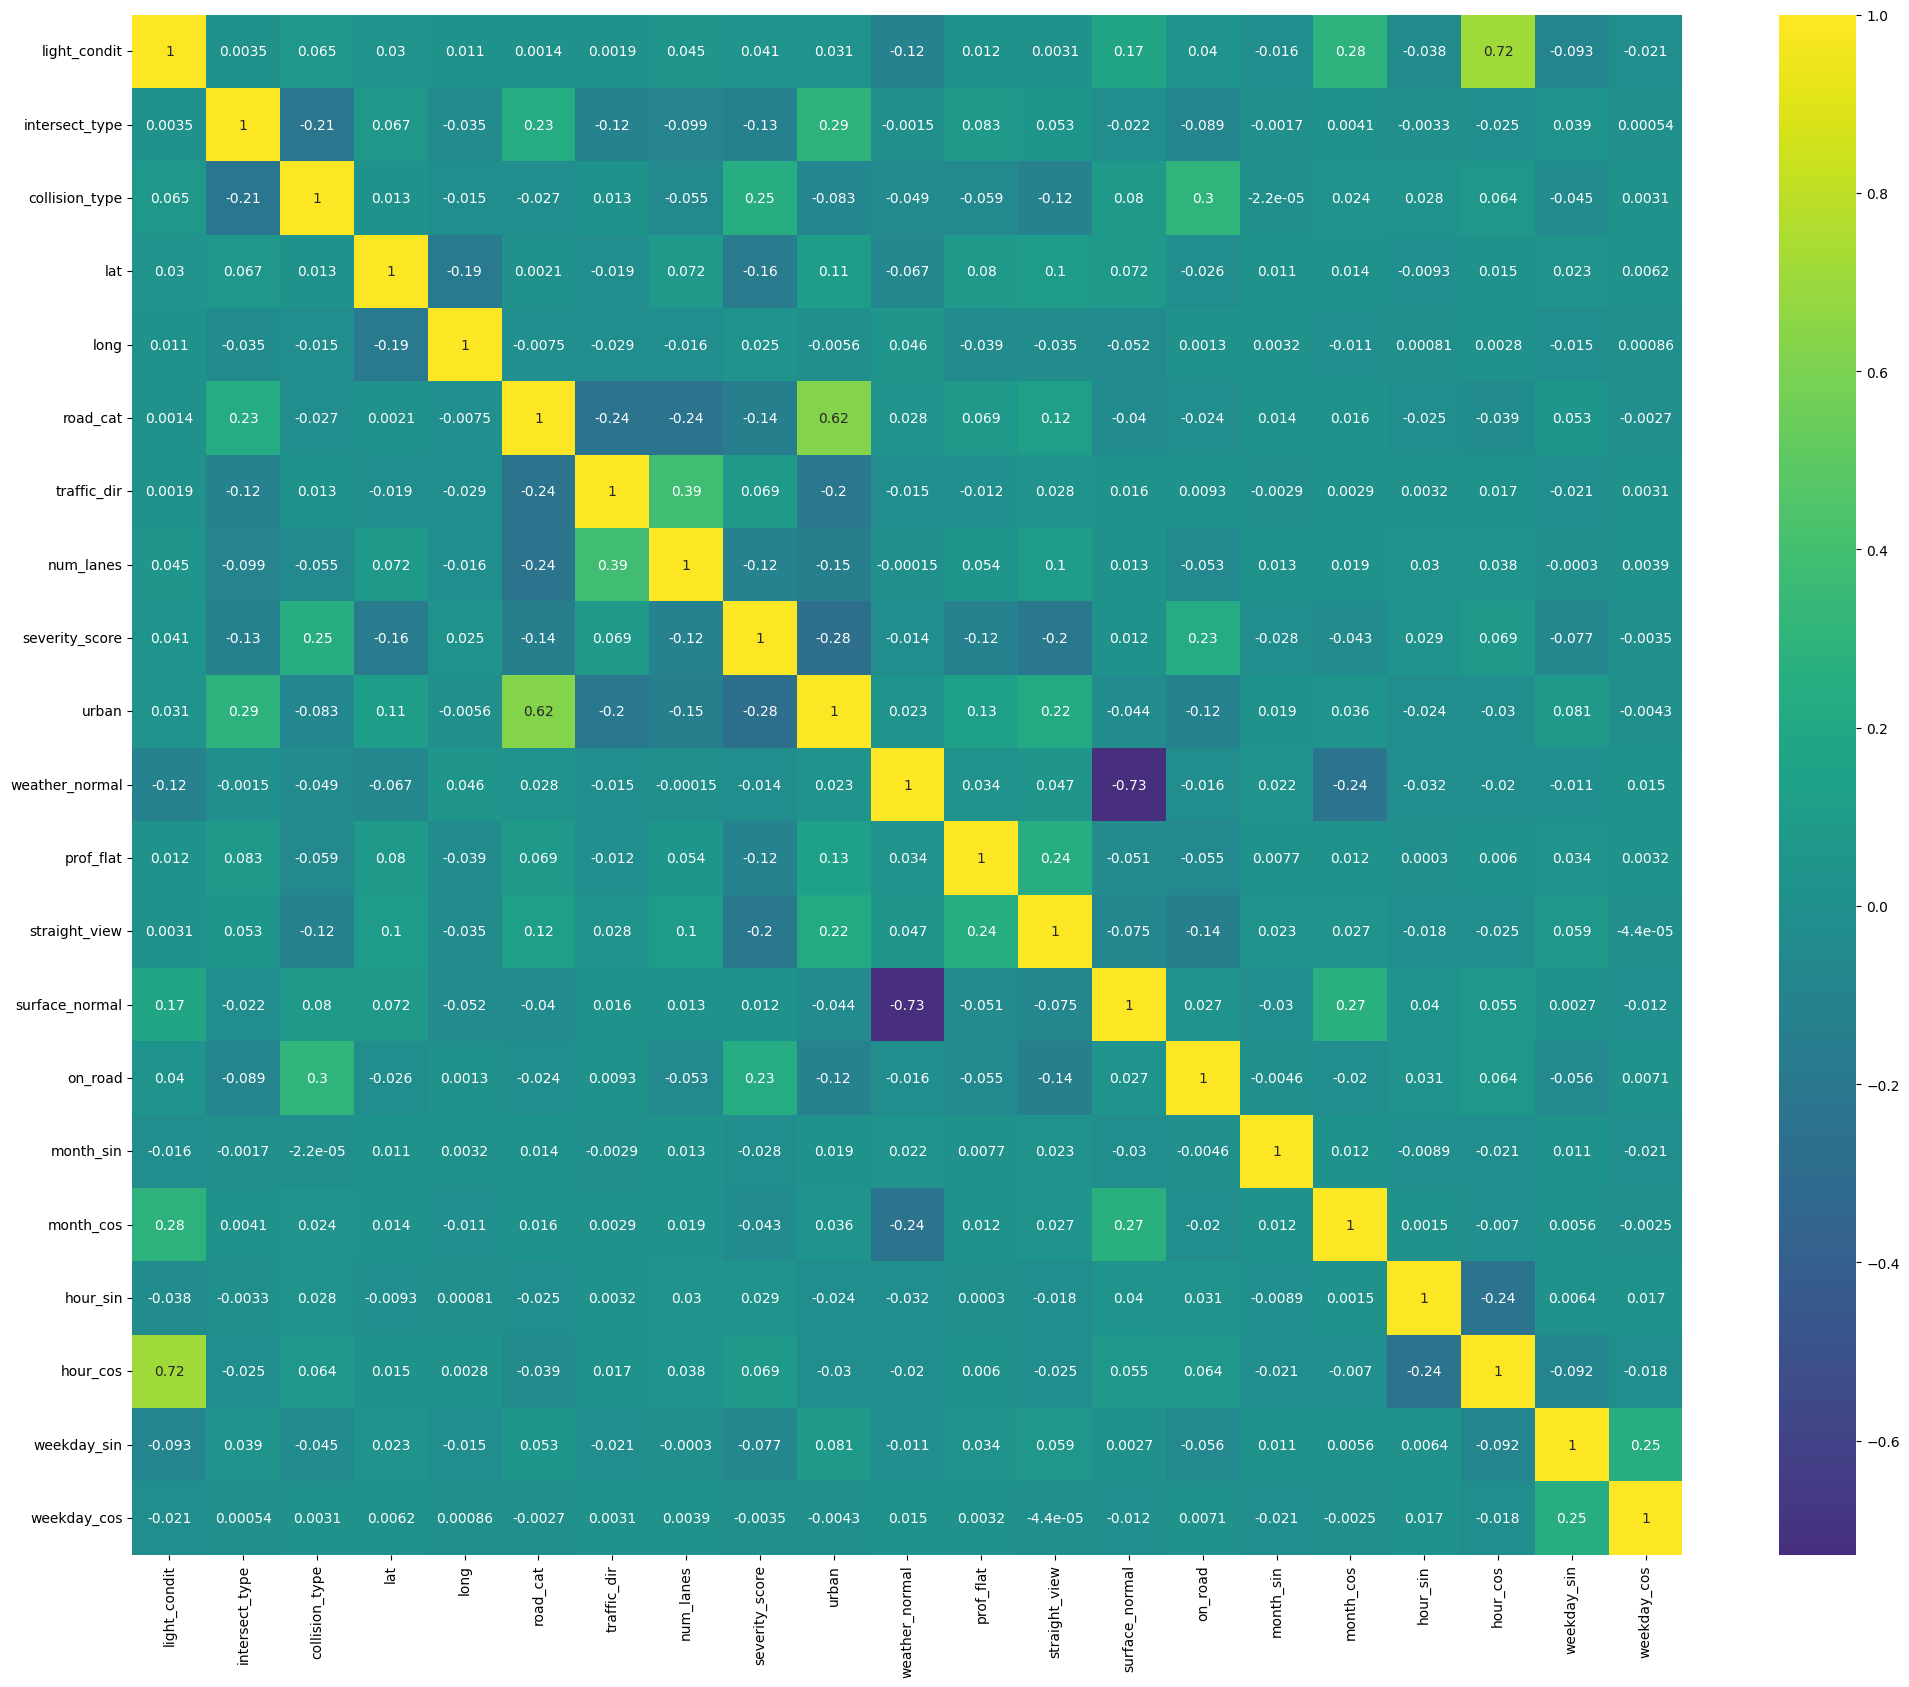

In [3]:
# make corr df: excluding categorical variables since correlation doesn't make sense with them
corrdf = train.copy()

plt.figure(figsize=(25,20))
sns.heatmap(
    corrdf.corr(method='spearman'),
    annot=True, 
    cmap="viridis",
    center=0
)
plt.show()

As one can see from the plot, there are not many correlations above $|0.7|$. However, I will print them out.

In [4]:
results = []

# calculate spearman's Rho
for i, var1 in enumerate(corrdf.columns):
    for j, var2 in enumerate(corrdf.columns):
        if i < j:  # don't save correlation twice
            corr, p_value = spearmanr(corrdf[var1], corrdf[var2])  
            if abs(corr) >= 0.7 and p_value < 0.05:  
                results.append([var1, var2, round(corr, 4), round(p_value, 3)])

results_df = pd.DataFrame(results, columns=['Variable 1', 'Variable 2', 'Spearman\'s R', 'p-value'])

markdown_df = results_df.sort_values(by='Spearman\'s R').to_markdown()

print(markdown_df)

|    | Variable 1     | Variable 2     |   Spearman's R |   p-value |
|---:|:---------------|:---------------|---------------:|----------:|
|  1 | weather_normal | surface_normal |        -0.7278 |         0 |
|  0 | light_condit   | hour_cos       |         0.7162 |         0 |


The two features `weather_normal` and `surface_normal` show high correlation which is based on the meaning of both variables, i.e. that weather rainy also refers to a wet surface. So far, I will keep these features. In case I run into problems in the estimation, this is a first point to return to.
In addition, the features `light_condit` and `hour_cos` show high correlation, which also make sense, since light conditions depend on the hours of the day to some extent (day or night). So far, I will keep it. If I run into problems in the estimation, this is a first point to get back to.

Below I do another check for categorical variables, confirming that Cramers V is not too high, since Spearman's $\rho$ might not capture the relation well. However, keep in mind to not regard the numerical features in the output.

In [5]:
# Cross check for categorical variables with Cramers V
# Excluding target and quasi-numerical features lat and long
X = train.drop(columns=['severity_score', 'lat', 'long'], axis=1)
y = train['severity_score']

# Calculate the contingency matrix for each pair of features
contingency_matrices = {}
for feature in X.columns:
    contingency_matrix = pd.crosstab(X[feature], y)
    contingency_matrices[feature] = contingency_matrix

# Calculate the V Cramer for each pair of features
feature_scores = {}
for feature, contingency_matrix in contingency_matrices.items():
    # Calculate the chi2 and the p-value
    chi2, _, _, _ = chi2_contingency(contingency_matrix)
    n = contingency_matrix.sum().sum()
    # Calculate the V Cramer
    cramer_v = np.sqrt(chi2 / (n * (min(contingency_matrix.shape) - 1)))
    feature_scores[feature] = cramer_v

# Sort the features based on their V Cramer score
sorted_features = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)
sorted_features

[('collision_type', 0.3894567421812858),
 ('on_road', 0.38486008116926407),
 ('urban', 0.38342183156081383),
 ('road_cat', 0.2591401561989026),
 ('straight_view', 0.2585415921056758),
 ('intersect_type', 0.25653675675100085),
 ('traffic_dir', 0.1747299340071503),
 ('light_condit', 0.15647516131514633),
 ('prof_flat', 0.1537622126709544),
 ('num_lanes', 0.1362773626941073),
 ('surface_normal', 0.10035812472723699),
 ('weekday_sin', 0.09878667010736411),
 ('weekday_cos', 0.0987866701073641),
 ('hour_cos', 0.08809456708646371),
 ('hour_sin', 0.08578961958022861),
 ('weather_normal', 0.07878747167244353),
 ('month_cos', 0.0740985310930594),
 ('month_sin', 0.07397077681187686)]

None of the values above is close to be a problem.

# Select K Best

In [6]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

# we might drop up to a third of variables
sel = SelectKBest(score_func=mutual_info_regression)
# score_func to detect also non-linear relations

sel.fit(
    train.drop(columns='severity_score', axis=1),
    train['severity_score']
)


SelectKBest(score_func=<function mutual_info_regression at 0x165bff240>)

Let's plot the selection and get out the names which variables were killed. 

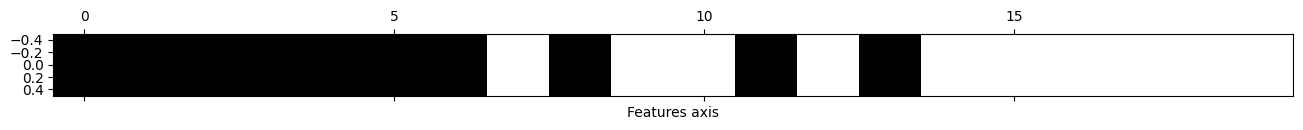

#### NOT SELECTED COLUMNS#####

Index(['num_lanes', 'weather_normal', 'prof_flat', 'surface_normal',
       'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'weekday_sin',
       'weekday_cos'],
      dtype='object')
#### SELECTED COLUMNS#####

Index(['light_condit', 'intersect_type', 'collision_type', 'lat', 'long',
       'road_cat', 'traffic_dir', 'urban', 'straight_view', 'on_road'],
      dtype='object')


In [7]:
mask = sel.get_support()

# make plot
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Features axis')
plt.show()

# give unselected out
print('#### NOT SELECTED COLUMNS#####', end='\n\n')
print(train.drop(columns='severity_score', axis=1).columns[~mask])
print('#### SELECTED COLUMNS#####', end='\n\n')
print(train.drop(columns='severity_score', axis=1).columns[mask])

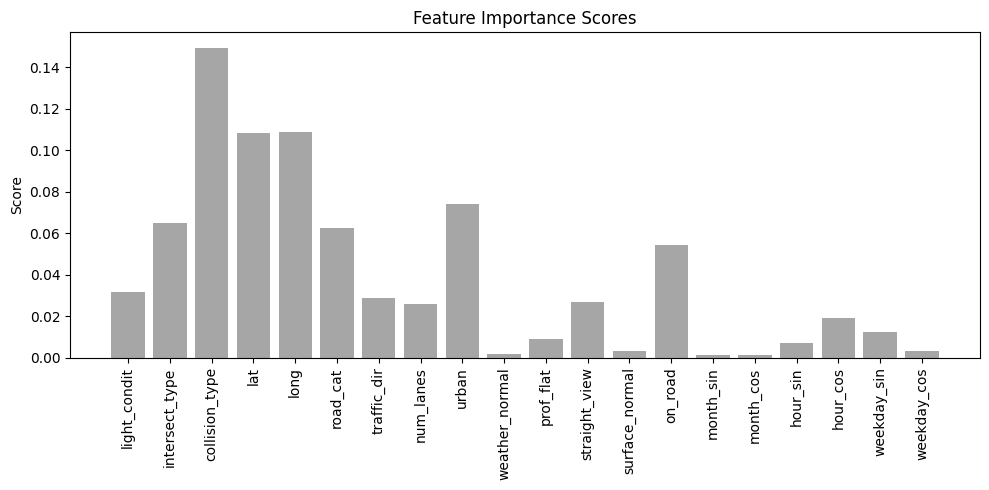

In [8]:
scores = sel.scores_  # Feature importance scores

# Create a DataFrame for clarity
feature_importance = pd.DataFrame({
    'Feature': train.drop(columns='severity_score', axis=1).columns,
    'Selected': mask,
    'Score': scores
})

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.bar(feature_importance['Feature'], feature_importance['Score'], color='gray', alpha=0.7)
plt.xticks(rotation=90)
plt.title('Feature Importance Scores')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

Overall, importances are quite low. I will test, if this smaller data set works better.

# PCA

Hence, we still have some dimensionality, we could also do the base models with a dataset processed by PCA to check if models achieve better scores. As threshold for the components, we choose 90% of variance explained by components.

In [9]:
# initiate the method with threshold
pca = PCA(n_components=0.9)

# split X, y 
X_train = train.drop(columns='severity_score', axis=1)
y_train = train['severity_score']

# Fit the model 
X_train_pca = pca.fit_transform(X_train)

In [10]:
variance_explained = pca.explained_variance_ratio_
variance_explained
# Just a single factor

array([0.36066576, 0.21882045, 0.08840179, 0.06106222, 0.03488493,
       0.02976456, 0.02744229, 0.0264179 , 0.0256107 , 0.02420918,
       0.02340879])

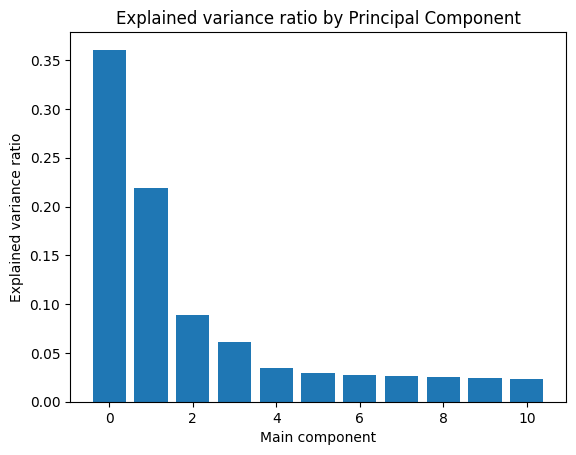

In [11]:
# explained variance ratio by each axis constructed by the PCA
# Plot first
plt.figure()
plt.bar(range(len(variance_explained)), variance_explained)
plt.xlabel('Main component')
plt.ylabel('Explained variance ratio')
plt.title('Explained variance ratio by Principal Component')
plt.show()


In [12]:
factor_loadings = pca.components_
df_factor_loadings = pd.DataFrame(
    factor_loadings, 
    columns=X_train.columns, 
)

df_factor_loadings

,light_condit,intersect_type,collision_type,lat,long,road_cat,traffic_dir,num_lanes,urban,weather_normal,prof_flat,straight_view,surface_normal,on_road,month_sin,month_cos,hour_sin,hour_cos,weekday_sin,weekday_cos
0,-0.001796,-0.014940,-0.004494,-0.494294,0.868584,-0.002681,-0.006880,-0.018734,-0.007103,0.011828,-0.009261,-0.009731,-0.012711,0.001062,-0.000563,-0.004536,0.000984,-0.000633,-0.005144,0.001231
1,0.035785,0.010976,0.000447,0.866246,0.494925,-0.000600,-0.009906,0.041826,0.024202,-0.010130,0.011403,0.015911,0.010723,-0.003469,0.006577,0.005241,-0.003539,0.009850,0.006191,0.000683
2,0.896346,-0.002666,0.040658,-0.038208,-0.015572,-0.005281,0.013535,0.076530,0.011402,-0.044468,0.003463,0.000331,0.060584,0.013786,0.003204,0.180896,-0.025303,0.376796,-0.076137,-0.002809
3,-0.068673,-0.168288,-0.010777,-0.026527,-0.000619,-0.382903,0.293195,0.833826,-0.186144,0.001967,0.003291,0.014130,0.003509,-0.010540,0.010126,-0.014311,0.048158,-0.012829,-0.019511,0.011846
4,0.024520,0.443557,-0.415048,-0.039908,-0.000526,0.464461,-0.011038,0.380767,0.341490,0.016660,0.094739,0.136780,-0.030920,-0.126819,0.094425,0.112791,-0.001537,-0.084569,0.274593,-0.046468
5,0.009597,-0.056065,0.135699,-0.002911,0.004600,-0.043907,-0.015039,-0.056933,-0.023648,-0.181699,-0.013010,-0.017733,0.189375,0.021975,0.027139,0.585862,0.638397,-0.269298,0.229968,0.159982
6,0.053196,0.067937,-0.044422,0.001563,-0.001574,0.007018,-0.003188,0.013255,0.006864,0.078938,0.008575,-0.003952,-0.075713,0.003318,-0.491664,-0.291776,0.123313,0.099277,0.215929,0.761365
7,0.030463,0.175553,-0.080315,0.004059,0.001037,0.069960,-0.017835,0.049103,0.043263,0.038364,0.010540,-0.009183,-0.038813,0.000655,-0.466434,-0.236662,0.562976,-0.001207,-0.458337,-0.385395
8,0.073188,-0.010091,0.134764,-0.001519,-0.005182,0.105490,-0.028669,0.030886,0.048910,0.112157,0.007888,0.001050,-0.110055,0.047595,0.694785,-0.460441,0.441321,0.067862,-0.064902,0.189003
9,0.092806,-0.133239,0.072801,0.000655,-0.001224,-0.111451,-0.013289,-0.061516,-0.048306,0.041513,-0.001098,0.002339,-0.039946,0.006461,-0.128513,-0.307221,0.146977,0.105595,0.772579,-0.453561


In [13]:
X_train_pca = pd.DataFrame(X_train_pca, columns=[f"PC{i}" for i in range(1, 12)])
train_pca = pd.concat([X_train_pca, y_train.reset_index(drop=True)], axis=1)
train_pca.to_csv('data/processed/train_pca.csv')

In [14]:
test = pd.read_csv('data/processed/test_eng.csv')

X_test = test.drop(columns='severity_score', axis=1)
y_test = test['severity_score']

X_test_pca = pca.transform(X_test)

X_test_pca = pd.DataFrame(X_test_pca, columns=[f"PC{i}" for i in range(1, 12)])
test_pca = pd.concat([X_test_pca, y_test.reset_index(drop=True)], axis=1)

test_pca.to_csv('data/processed/test_pca.csv')

# Save data sets

In [15]:
# Loading data
train = pd.read_csv('data/processed/train_eng.csv')

In [16]:
# K-Best selection

# drop variables first/second step and save as train_sel.csv and test_sel.csv
train_ksel = train.drop(
    columns=[
        'weather_normal', 'prof_flat', 'straight_view', 'surface_normal',
        'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'weekday_sin',
        'weekday_cos'
    ],
    axis=1
)

train_ksel.to_csv('data/processed/train_ksel.csv')

test_ksel = test.drop(
    columns=[
        'weather_normal', 'prof_flat', 'straight_view', 'surface_normal',
        'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'weekday_sin',
        'weekday_cos'    
    ],    
    axis=1
)

test_ksel.to_csv('data/processed/test_ksel.csv')